In [250]:
## For Data
import pandas as pd
import numpy as np

## For missing variables
import missingno as msno

## For vizualisation
import matplotlib.pyplot as plt
import seaborn as sns

## For statistical testing
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

##For data preparation
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

## For Machine Learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model,metrics,decomposition
import xgboost as xg

## For evaluation
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error


## For warnings
import warnings
warnings.filterwarnings("ignore")


In [138]:
data = pd.read_csv("insurance.csv")
df = data.copy()
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [4]:
# lets start with inital data analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<AxesSubplot:>

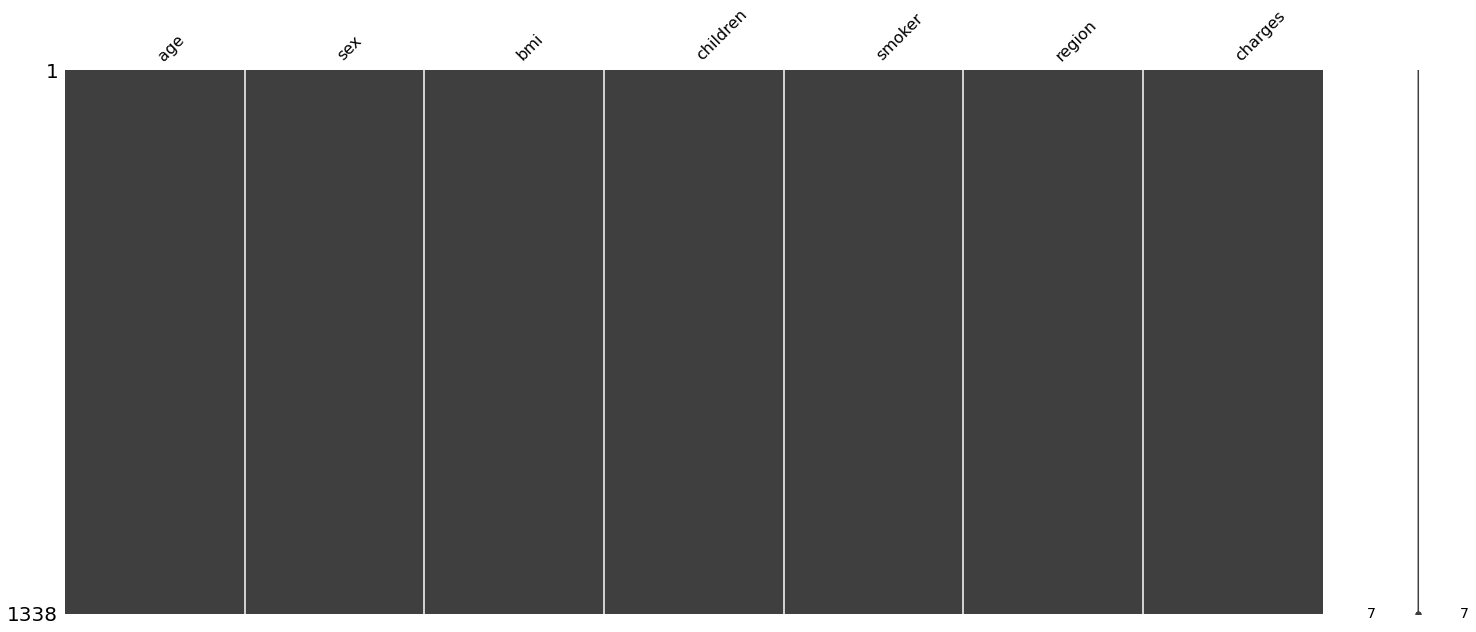

In [6]:
msno.matrix(df)

In [7]:
# data set has 0 NA's

# Data Analysis

In [8]:
# let's first analys how our target variable is distributed and wether it has otliers

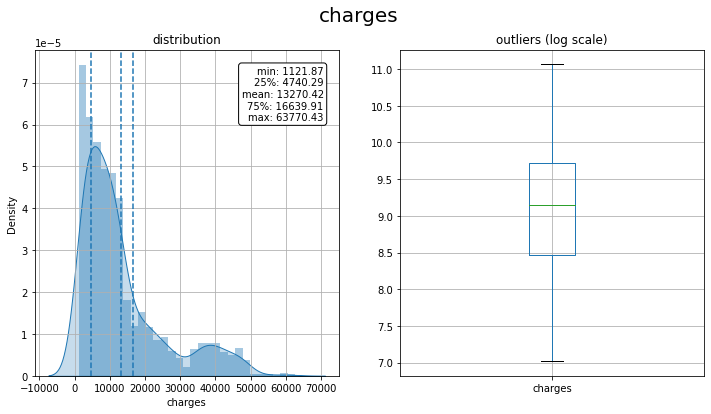

In [9]:
x = "charges"
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,6), sharex=False, sharey=False)
fig.suptitle(x, fontsize=20,)
### distribution
ax[0].title.set_text('distribution')
variable = df[x].fillna(df[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = df[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_df = pd.DataFrame(df[x])
tmp_df[x] = np.log(tmp_df[x])
tmp_df.boxplot(column=x, ax=ax[1])
plt.show()

As we can see the data is highly skewed to the right with average charge being $13.3K
but we do not have any outliers regarding chargs

In the below analysis we would conduct appropriate data vizualisation tecnigues and try to understand relationship and use statistical testing to futher back our hypotesis 

## Analysing Region column

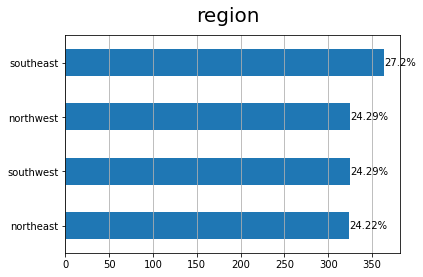

In [11]:
x = "region"

ax = df[x].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()

We have 4 regions nearly egualy selected.

In [13]:
# now lets see how different region affects the hospital charges 

<AxesSubplot:title={'center':'bins'}, xlabel='charges'>

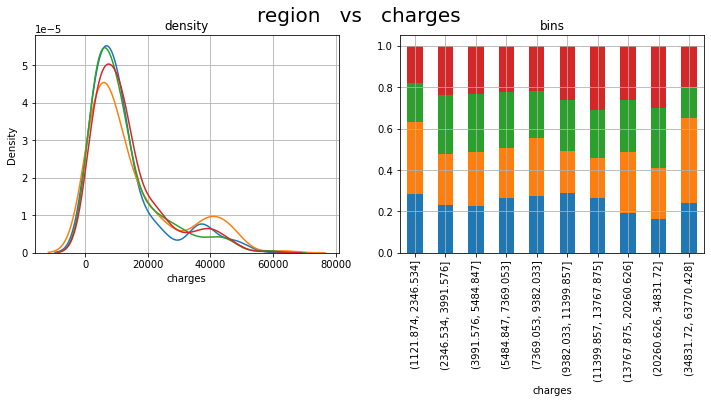

In [14]:
x, y = "region", "charges"
cat,num = "region", "charges"

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4),  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in df[cat].unique():
    sns.distplot(df[df[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(df[num], q=np.linspace(0,1,11))
tmp = df.groupby([cat, pd.cut(df[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)


<Figure size 1440x936 with 0 Axes>

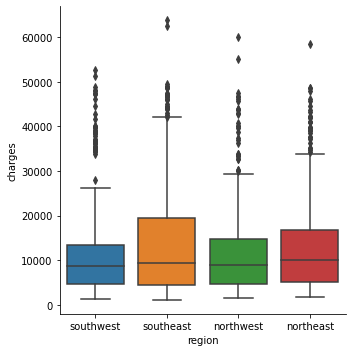

In [15]:
x, y = "region", "charges"
cat,num = "region", "charges"
fig = plt.figure(figsize=(20,13))
# ### boxplot   
ax[0].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=df, kind="box", ax=ax[0])
ax[0].grid(True)
plt.show()

from the charts above it is clear that region column does not poses ability to predict
first off all distribution of all regions are nearly the same
secondly when we beand charges there were lacking any kind of pattern
lastly all of the regions poses a lot of positive outliers

In [17]:
# more detailed analysis will be taken for feature selection

Anova-F test for Region and Charges

In [75]:
cat, num = "region", "charges"
model = smf.ols(num+' ~ '+cat, data=df).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.031)


p-value is less than 0.05 so we can regect the null hypotesis

## Gender analysis

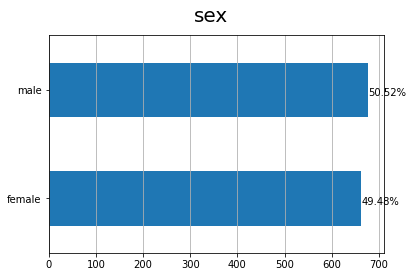

In [18]:
x = "sex"

ax = df[x].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()

In [19]:
# yet again we see a balanced data for this variable

<AxesSubplot:title={'center':'bins'}, xlabel='charges'>

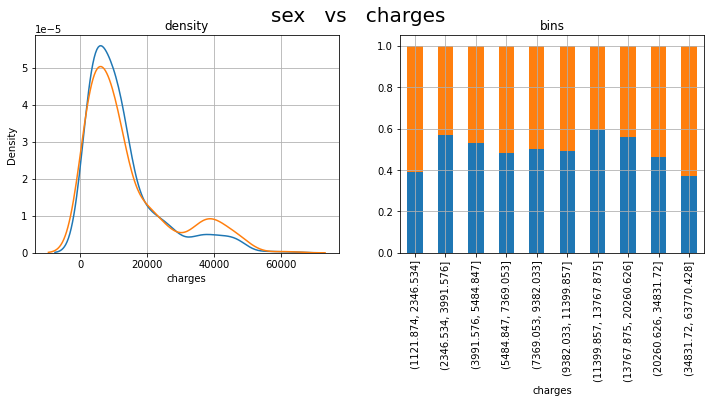

In [20]:
x, y = "sex", "charges"
cat,num = "sex", "charges"
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4),  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in df[cat].unique():
    sns.distplot(df[df[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(df[num], q=np.linspace(0,1,11))
tmp = df.groupby([cat, pd.cut(df[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)


<Figure size 1440x936 with 0 Axes>

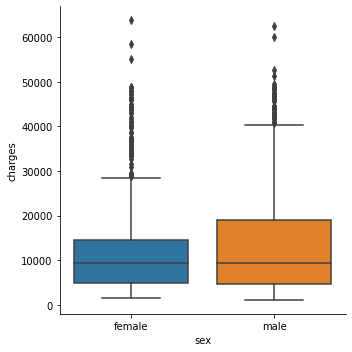

In [21]:
x, y = "sex", "charges"
cat,num = "sex", "charges"
fig = plt.figure(figsize=(20,13))
# ### boxplot   
ax[0].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=df, kind="box", ax=ax[0])
ax[0].grid(True)
plt.show()

In [22]:
# In gender columns we alse see the lack of distinguality
# interesting factor is among male we see a strange second local hight in the range of $40K
# which is 2 times that of females 
# there might be several reasons for that as there is some particular factor that affects man which
# makes male client

In [74]:
cat, num = "sex", "charges"
model = smf.ols(num+' ~ '+cat, data=df).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.036)


## Smoker Analysis

<AxesSubplot:title={'center':'bins'}, xlabel='charges'>

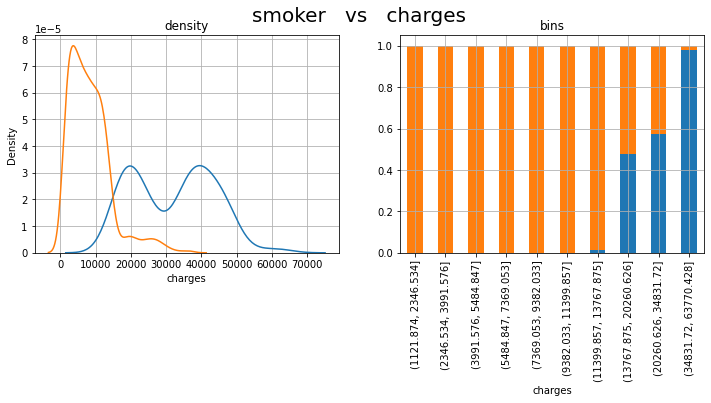

In [23]:
x, y = "smoker", "charges"
cat,num = "smoker", "charges"
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4),  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in df[cat].unique():
    sns.distplot(df[df[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(df[num], q=np.linspace(0,1,11))
tmp = df.groupby([cat, pd.cut(df[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)


<Figure size 1440x936 with 0 Axes>

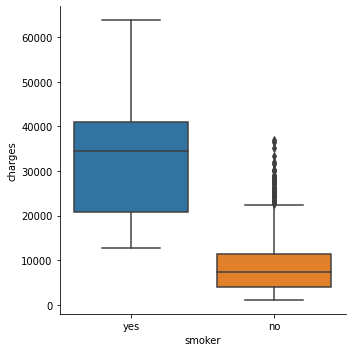

In [24]:
x, y = "smoker", "charges"
cat,num = "smoker", "charges"
fig = plt.figure(figsize=(20,13))
# ### boxplot   
ax[0].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=df, kind="box", ax=ax[0])
ax[0].grid(True)
plt.show()

In [73]:
cat, num = "smoker", "charges"
model = smf.ols(num+' ~ '+cat, data=df).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.0)


## Analysis based on Age distribution

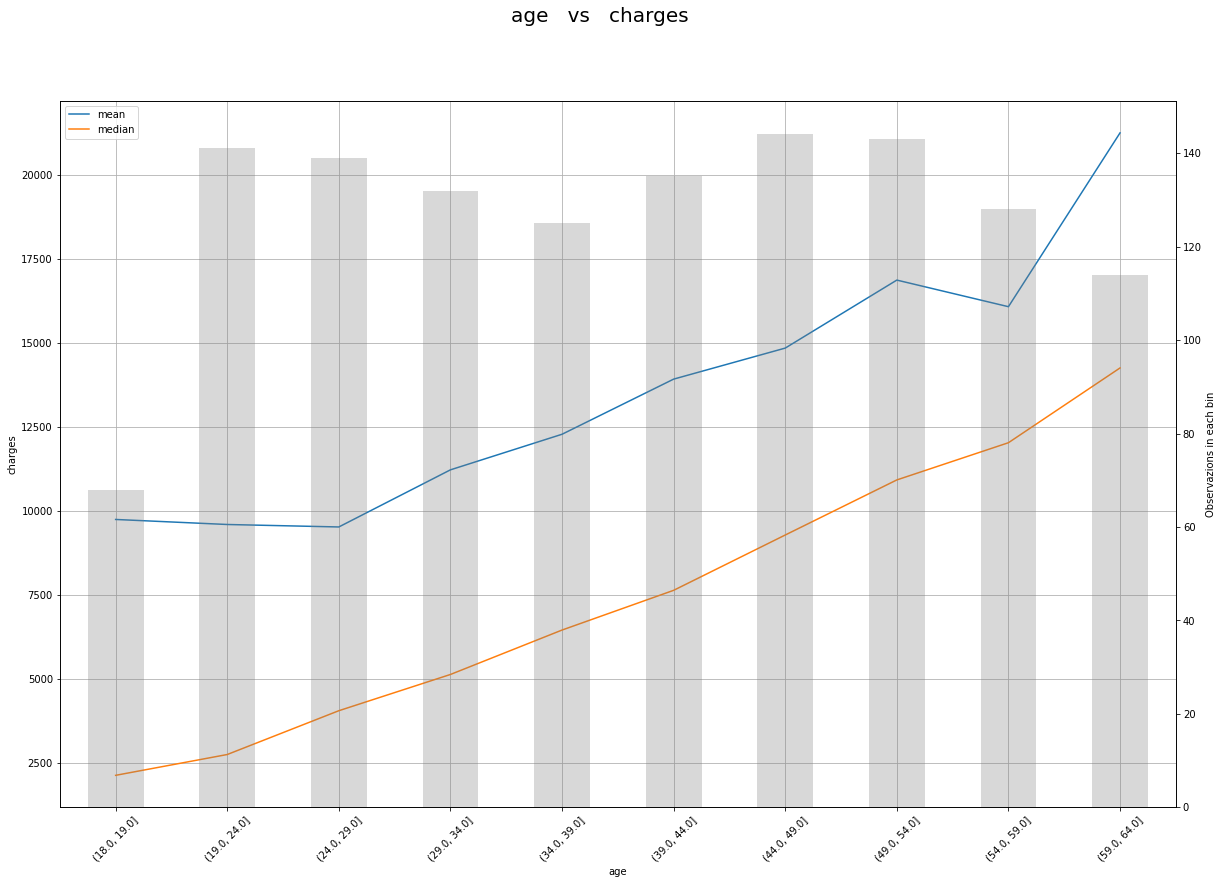

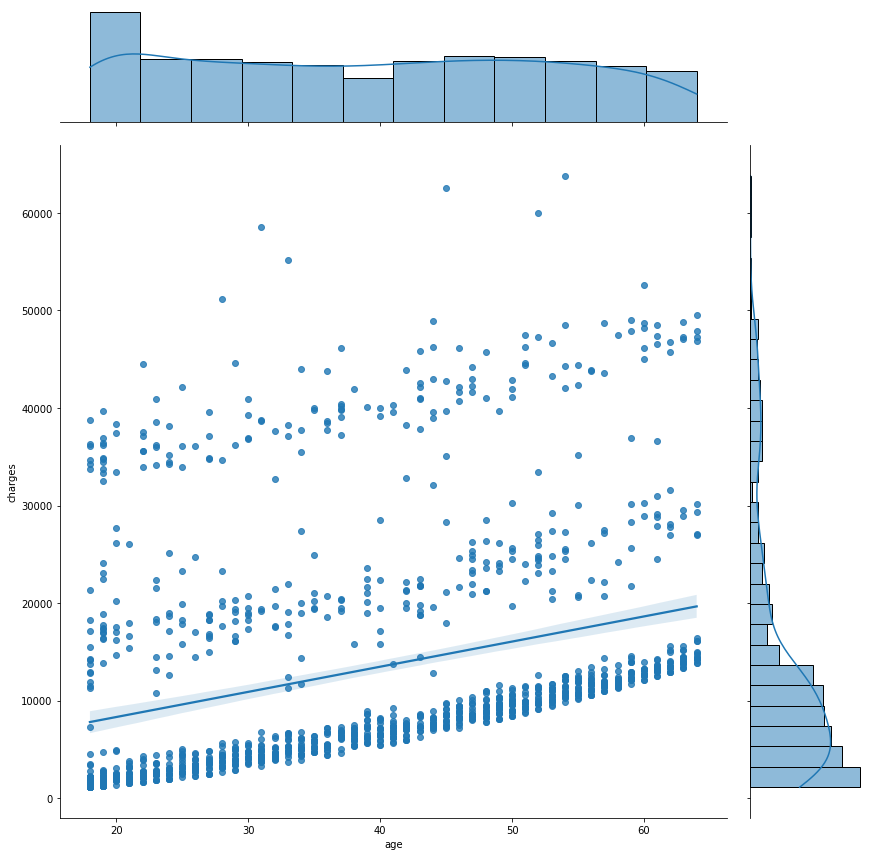

In [33]:
x, y = "age", "charges"
### bin plot
figsize = (15,9)
df_noNan = df[df[x].notnull()]
breaks = np.quantile(df_noNan[x], q=np.linspace(0, 1, 11))
groups = df_noNan.groupby([pd.cut(df_noNan[x], bins=breaks, 
           duplicates='drop')])[y].agg(['mean','median','size'])
fig, ax = plt.subplots(figsize=(20,13))
fig.suptitle(x+"   vs   "+y, fontsize=20)
groups[["mean", "median"]].plot(kind="line", ax=ax)
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel("Observazions in each bin")
plt.show()
### scatter plot
sns.jointplot(x=x, y=y, data=df, dropna=True, kind='reg', 
              height=int((figsize[0]+figsize[1])/2) )
plt.show()

As we can see there is obvious upword trend in these diagrams. We can comfortably say that as age increses the cost of medical treatment increses. Moreover there is a strange peculiarity in data it looks like it is split to 3 different category of people. In fact i can say that as smoking played a major factor my early assumption is the top part of the dataset is smokers and the bottom one is non smokers cost change by age.  

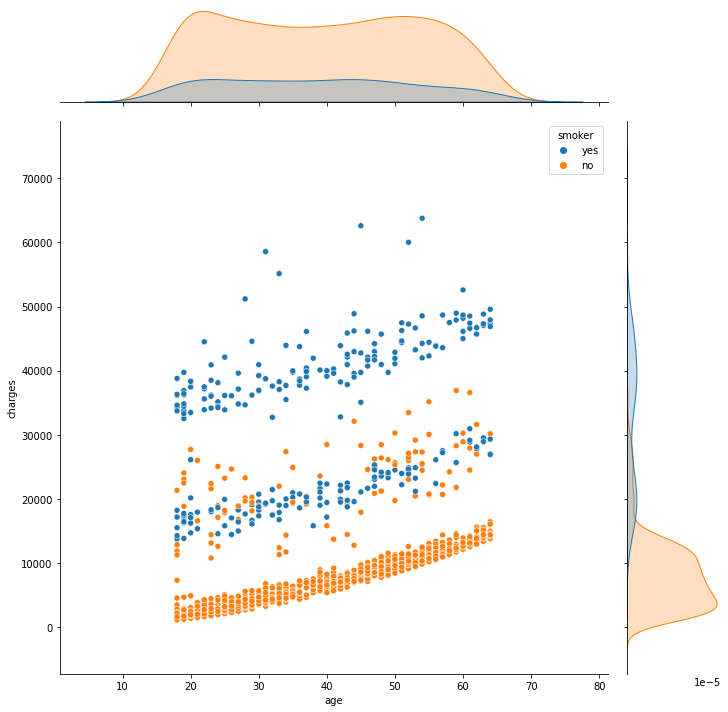

In [82]:
x, y, z = "age", "charges", "smoker"
sns.jointplot(x=x, y=y, data=df, hue=z ,height=10 )
plt.show()

As it was assumued bottom half of the population is non smokers and top one is smokers. In the middle part we can see both smokers and non smokers which indicates that the reson why some smokers got lover charges and some of non smokers got higher charges is something different. We will try to explor it further.

In [76]:
x, y = "age", "charges"
df_noNan = df[df[x].notnull()]
coeff, p = scipy.stats.pearsonr(df_noNan[x], df_noNan[y])
coeff, p = round(coeff, 3), round(p, 3)
conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Pearson Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")

Pearson Correlation: 0.299 Significant (p-value: 0.0)


we reject the null-hypotesis as p value is below0.05 but the corrolation between age and charges is low as it is below 0.3

## BMI analysis

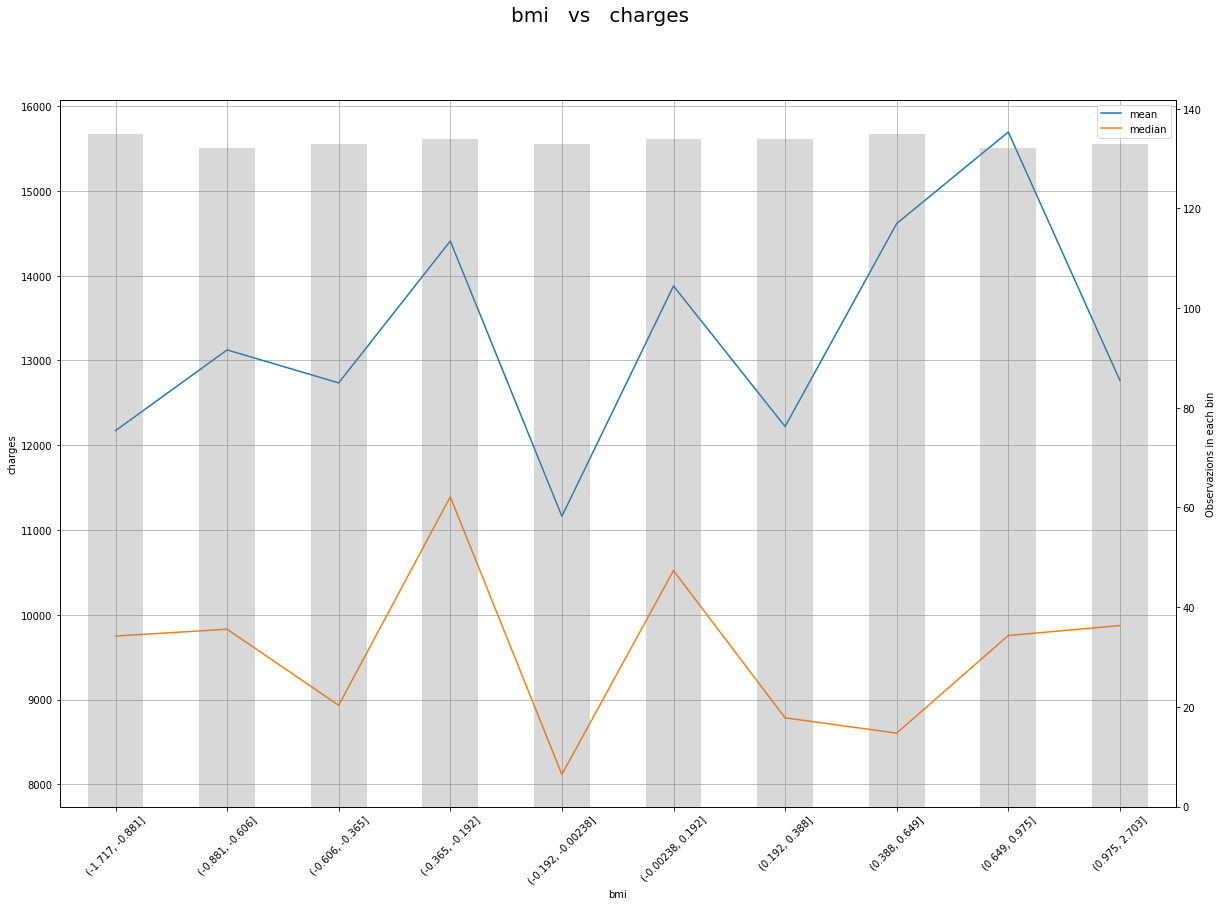

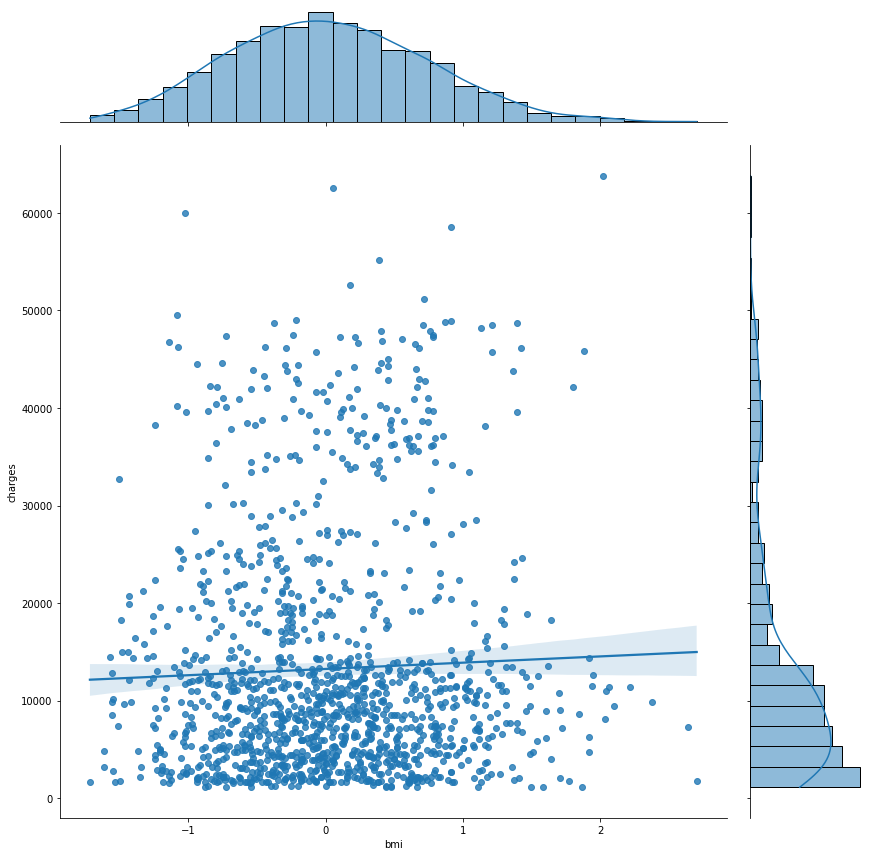

In [165]:
x, y = "bmi", "charges"
### bin plot
figsize = (15,9)
df_noNan = df[df[x].notnull()]
breaks = np.quantile(df_noNan[x], q=np.linspace(0, 1, 11))
groups = df_noNan.groupby([pd.cut(df_noNan[x], bins=breaks, 
           duplicates='drop')])[y].agg(['mean','median','size'])
fig, ax = plt.subplots(figsize=(20,13))
fig.suptitle(x+"   vs   "+y, fontsize=20)
groups[["mean", "median"]].plot(kind="line", ax=ax)
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel("Observazions in each bin")
plt.show()
### scatter plot
sns.jointplot(x=x, y=y, data=df, dropna=True, kind='reg', 
              height=int((figsize[0]+figsize[1])/2) )
plt.show()

Personaly I was hoping to see a greater relationship between bmi and charges. Never the less there is a strong positive relationship between bmi and overal cost. As peoples BMI scores increases the overal cost of treatment increases.
In the upper side of the scatter plot we have a cluster looking group most probably it will consist of smokers.
Moreover in binned and stakked bar/line chart we can see that there are 3 bins that even though bmi increased the cost decreased it can be simpy explained as in the sample of this data group there are other factors which may affect

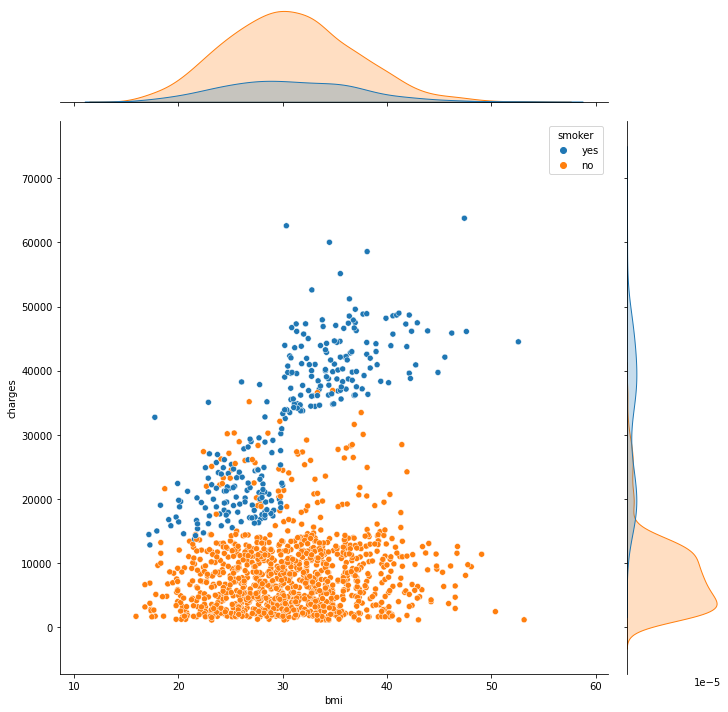

In [80]:
x, y, z = "bmi", "charges", "smoker"
sns.jointplot(x=x, y=y, data=df, hue=z ,height=10 )
plt.show()

From the scaterplot it is visible that bmi has a strong affect to smokers. In fact people who are smoker and have less bmi than 30 they tend to have lover medical charges. But this chart fails to showcase why some non-smoke's have higher medical charges. This one is yet to be discover.

In [77]:
x, y = "bmi", "charges"
df_noNan = df[df[x].notnull()]
coeff, p = scipy.stats.pearsonr(df_noNan[x], df_noNan[y])
coeff, p = round(coeff, 3), round(p, 3)
conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Pearson Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")

Pearson Correlation: 0.198 Significant (p-value: 0.0)


we reject the null-hypotesis as p value is below 0.05 but the corrolation between bmi and charges is low as it is below 0.3

## Children Analysis

children data is categorical but as it was already encoded it is labeld as intiger.

<AxesSubplot:title={'center':'bins'}, xlabel='charges'>

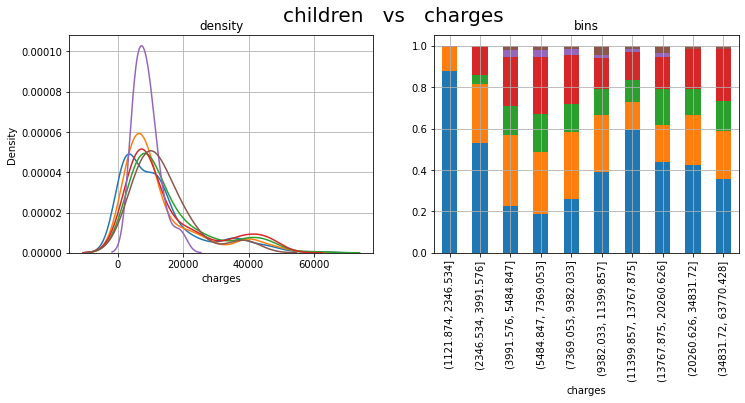

In [50]:
x, y = "children", "charges"
cat,num = "children", "charges"
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4),  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in df[cat].unique():
    sns.distplot(df[df[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(df[num], q=np.linspace(0,1,11))
tmp = df.groupby([cat, pd.cut(df[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)


<Figure size 1440x936 with 0 Axes>

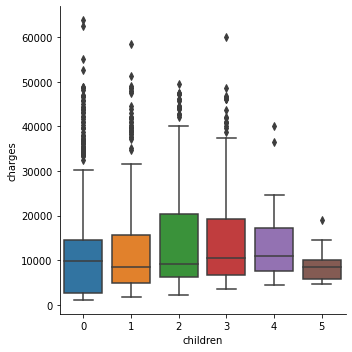

In [45]:
x, y = "children", "charges"
cat,num = "children", "charges"
fig = plt.figure(figsize=(20,13))
# ### boxplot   
ax[0].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=df, kind="box", ax=ax[0])
ax[0].grid(True)
plt.show()

children number has a slight affect on charges. 4 and 5 children are in fact simply lack enough data to say something. 
Despite from that there is a slight upword trend  

In [139]:
df["children"].replace({1:1,2:2,3:3,4:3,5:3},inplace=True)

In [140]:
df["children"].value_counts()

0    574
1    324
2    240
3    200
Name: children, dtype: int64

<AxesSubplot:title={'center':'bins'}, xlabel='charges'>

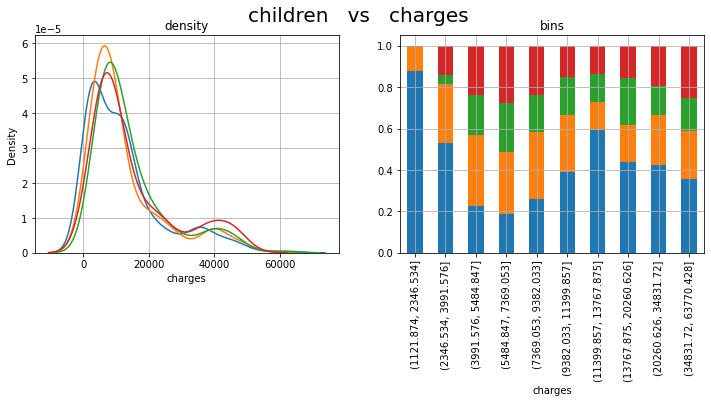

In [62]:
x, y = "children", "charges"
cat,num = "children", "charges"
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4),  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in df[cat].unique():
    sns.distplot(df[df[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(df[num], q=np.linspace(0,1,11))
tmp = df.groupby([cat, pd.cut(df[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)


<Figure size 1440x936 with 0 Axes>

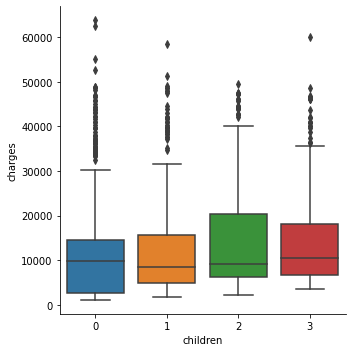

In [63]:
x, y = "children", "charges"
cat,num = "children", "charges"
fig = plt.figure(figsize=(20,13))
# ### boxplot   
ax[0].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=df, kind="box", ax=ax[0])
ax[0].grid(True)
plt.show()

one thing to concider is in this case 3 represents 3 and more children. Now we can see a clear pattern without having imbalanced 4 and 5 values.
people with no children domimnates the lower charges and 3 and more children on higher charegs however we should concider that usually people with lover ages tend to have no or less children thouse we should not only rely on this hypotesis.


In [72]:
cat, num = "children", "charges"
model = smf.ols(num+' ~ '+cat, data=df).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.002)


# Data preprocessing

We have several problems to solve;

1) we should check dublicates

2) there are categorical datas which should be encoded 

3) there are numerical datas which should be scaled (sclaing is performed inorder to put numerical datas into same ratio for getting rid of modelling bias and for making it faster)

4) even thoug some variables should be normilized I will not do that inorder to save datas authenticity 

5) outliers there are different methodes for solving them in fact we should first analys the outliers to understand why did they occure. there are in general 3 main reasons why outliers occure. firstly by mechanical eror in this cases if possible we should go to the root of the data and replace with original value, if it is not possible we should discard that data as it is not valid. secondly, sampling erors in this case we have originally took data out of sample so we should get rid of it also. Thirdly, when the outlier is valid an it's occurence is based on some anomaly which occured. In this case we should either descard or left the outler based on our goal. In this project we do not have the original data's so removing them will increase our models overall performance but it will change our data. Based on this reason I will use robust scaling tecnigue which deals with outlers without discarding them.

6) we should check multicolinarity 


## Dealing with dublicates

In [141]:
df.shape

(1338, 7)

In [142]:
df.drop_duplicates(keep='first',inplace=True)
df.shape

(1337, 7)

we had one dublicated raw and we get rid of it

## Categorical data preparation

In [143]:
df_object = df.select_dtypes('object')
df_object.head()

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest


We will use dummy variables as region column is nominal data.

If it was an ordinal data lebel encoder would work better.

In [144]:
df_object = pd.get_dummies(df_object,drop_first=True)

## Numerical data preparation

In [146]:
df_num = df.select_dtypes('number')
df_num.drop(['charges'],axis=1,inplace=True)

In [148]:
num_cols = df_num.columns

In [149]:
R_scaler = RobustScaler()
df_num_rs = R_scaler.fit(df_num).transform(df_num)
df_num = pd.DataFrame(data = df_num_rs, columns = num_cols)

In [150]:
df = pd.concat([df_object,df_num,df['charges']],axis=1)

In [157]:
df.dropna(axis=0,inplace=True)

## Feature Selection

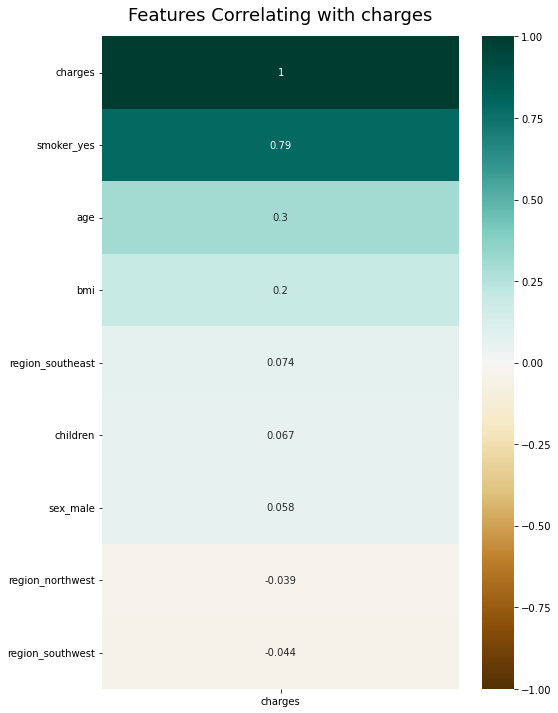

In [119]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['charges']].sort_values(by='charges', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with charges', fontdict={'fontsize':18}, pad=16);

As we have already discussed smoking is the strongest feature which affects charegs and southeast region has the highest impact among other regions 
In general most of the data has a small corolation.

correlation between 1-0.7 conciders strong, 0.7-0.3 medium, 0.3- bellow as week

In [161]:
df.shape

(1336, 9)

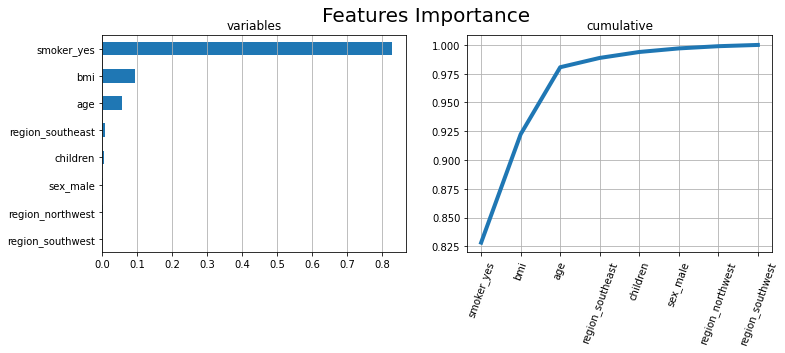

In [170]:
X = df.drop("charges", axis=1).values
y = df["charges"].values
feature_names = df.drop("charges", axis=1).columns
## call model
model = ensemble.GradientBoostingRegressor()
## Importance
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas df
df_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
df_importances['cumsum'] = df_importances['IMPORTANCE'].cumsum(axis=0)
df_importances = df_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4), sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
df_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot( kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
df_importances[["cumsum"]].plot(kind="line", linewidth=4,legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(df_importances)), xticklabels=df_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

smoking, bmi, age represented 3 most influential features in both cases.

In general we try to create best possible model with least possible feastures. In this case I willt try to run model with 3.

In [236]:
X_names = ["smoker_yes","bmi","age"]
X = df[X_names]

y= df["charges"]

In [233]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.3, random_state=123)

# Modeling

In [307]:
model_lr = linear_model.LinearRegression()

y_pred = model_lr.fit(X_train,y_train).predict(X_val)

In [308]:
print("Evaluation of Linear Regressor")
print('\n'"Explained variance score:")
print("With 3 features:", explained_variance_score(y_val, y_pred))

print('\n' "Mean absolute eror:")
print("With 3 features:", mean_absolute_error(y_val, y_pred))

print('\n' "Mean absolute percentage eror:")
print("With 3 features:", mean_absolute_percentage_error(y_val, y_pred))

print('\n' "R**2 score:")
print("With 3 features:", r2_score(y_val, y_pred))

Evaluation of Linear Regressor

Explained variance score:
With 3 features: 0.6626610845973847

Mean absolute eror:
With 3 features: 5082.475834553137

Mean absolute percentage eror:
With 3 features: 0.8186447636018799

R**2 score:
With 3 features: 0.6598517017905978


In [309]:
model_xgb = xg.XGBRegressor(objective ='reg:squarederror',n_estimators = 10000, seed = 123,booster="gblinear")

y_pred = model_xgb.fit(X_train,y_train).predict(X_val)

In [310]:
print("Evaluation of XGBoosting Regressor")

print("\n""Explained variance score:")
print("With 3 features:", explained_variance_score(y_val, y_pred))

print('\n' "Mean absolute eror:")
print("With 3 features:", mean_absolute_error(y_val, y_pred))

print('\n' "Mean absolute percentage eror:")
print("With 3 features:", mean_absolute_percentage_error(y_val, y_pred))

print('\n' "R**2 score:")
print("With 3 features:", r2_score(y_val, y_pred))

Evaluation of XGBoosting Regressor

Explained variance score:
With 3 features: 0.6626610797713621

Mean absolute eror:
With 3 features: 5082.476010053227

Mean absolute percentage eror:
With 3 features: 0.8186448444924465

R**2 score:
With 3 features: 0.6598516909646455


In [311]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=123)
y_pred = reg.fit(X_train,y_train).predict(X_val)


In [312]:
print("Evaluation of Gradient Boosting Regressor")
print('\n' "Explained variance score:")
print("With 3 features:", explained_variance_score(y_val, y_pred))

print('\n' "Mean absolute eror:")
print("With 3 features:", mean_absolute_error(y_val, y_pred))

print('\n' "Mean absolute percentage eror:")
print("With 3 features:", mean_absolute_percentage_error(y_val, y_pred))

print('\n' "R**2 score:")
print("With 3 features:", r2_score(y_val, y_pred))

Evaluation of Gradient Boosting Regressor

Explained variance score:
With 3 features: 0.664813089979049

Mean absolute eror:
With 3 features: 5007.0997482290395

Mean absolute percentage eror:
With 3 features: 0.8725916640278124

R**2 score:
With 3 features: 0.6597788294346019
